In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
!wget https://raw.githubusercontent.com/karpathy/makemore/refs/heads/master/names.txt
words = open('names.txt', 'r').read().splitlines()
words[:8]

--2025-02-07 20:53:04--  https://raw.githubusercontent.com/karpathy/makemore/refs/heads/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt’

names.txt           100%[===================>] 222.80K  --.-KB/s    in 0.01s   

2025-02-07 20:53:05 (17.8 MB/s) - ‘names.txt’ saved [228145/228145]



['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [ ]:
#build the vocab of chars and mapping to and from ints
chars = sorted(list(set(''.join(words)))) # sorted list of all unique chars in dataset
stoi = {s:i+1 for i,s in enumerate(chars)} # string to int mapping
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()} # int to string mapping
vocab_size = len(itos)

#building the dataset
block_size = 3 # context length -> how many previous chars we are using to predict the next

def build_dataset(words):
  X, Y = [], []
  for w in words:
      #print(w)
      context = [0] * block_size
      for ch in w + '.':
          ix = stoi[ch]
          X.append(context)
          Y.append(ix)
          #print(''.join(itos[i] for i in context), '--->', itos[ix])
          context = context[1:] + [ix] # crop and append
  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2]) # dev == validation
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [ ]:
# function that compares or manually made gradients to the autograd pytorch gradientsdef cmp(s, dt, t):
def cmp(s, dt, t):
 ex = torch.all(dt == t.grad).item()
 app = torch.allclose(dt, t.grad)
 maxdiff = (dt - t.grad).abs().max().item()
 print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

In [ ]:
n_embd = 10 # the dimenionality of the char embedding vectors
n_hidden = 64 # num of neurons in the hidden layer

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, n_embd), generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden, generator=g) * 0.1 # should be ueslesss bc of batch norm
# Layer 2
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.1
b2 = torch.randn(vocab_size, generator=g) * 0.1
#BatchNorm params
bngain = torch.randn(1, n_hidden) * 0.1 + 1.0
bnbias = torch.randn(1,n_hidden) * 0.1

# the initialization of some of these params is wonky b/c sometimes intializting
# with all zeros for example could mask an incorrect implememtaion of the backward pass

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
  torch.requires_grad = True

4137


In [ ]:
batch_size = 32
n = batch_size # shorter
ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y

In [ ]:
#forward pass

emb = C[Xb] # embed chars into vectors
emb.requires_grad = True
embcat = emb.view(emb.shape[0], -1) # concatinate the vectors
#linear layer 1
hprebn = embcat @ W1 + b1
# batch norm layer
bnmeani = 1/n*hprebn.sum(0, keepdim=True)
bndiff = hprebn - bnmeani
bndiff2 = bndiff**2
bnvar = 1/(n-1)*bndiff2.sum(0, keepdim=True)
bnvar_inv = (bnvar + 1e-5)**-0.5
bnraw = bndiff * bnvar_inv
hpreact = bngain * bnraw
#Non-linearity
h = torch.tanh(hpreact)
#linear layer 2
logits = h @ W2 + b2  # got logits
#cross entropy loss spelled out
logit_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logit_maxes # subtract max for numerical stability
counts = norm_logits.exp() # exponentiate logits to get the counts
counts_sum = counts.sum(1, keepdims=True)
counts_sum_inv = counts_sum**-1 # normilzing them so that we can get the probailities
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(n), Yb].mean()

# Pytorch backward pass
for p in parameters:
  p.grad = None
for t in [logprobs, probs, counts, counts_sum, counts_sum_inv,
          norm_logits, logit_maxes, logits, h, hpreact, bnraw,
          bnvar_inv, bnvar, bndiff2, bndiff, hprebn, bnmeani,
          embcat, emb]:
  t.retain_grad()
loss.backward()
loss

tensor(3.3494, grad_fn=<NegBackward0>)

In [ ]:
Yb

tensor([ 8, 14, 15, 22,  0, 19,  9, 14,  5,  1, 20,  3,  8, 14, 12,  0, 11,  0,
        26,  9, 25,  0,  1,  1,  7, 18,  9,  3,  5,  9,  0, 18])

In [ ]:
logprobs.shape

torch.Size([32, 27])

In [ ]:
logprobs[range(n), Yb] # all the probabilities at each of the Yb indices ALL of the unplucked out probabilities in logprobs are useless/ derivative = 0

tensor([-4.0558, -3.0847, -3.6391, -3.2794, -4.0920, -3.4660, -3.1276, -4.0615,
        -3.2165, -4.2962, -3.1322, -1.6500, -2.7998, -3.0003, -3.0016, -3.1559,
        -3.8452, -3.0353, -3.5757, -3.3413, -2.8281, -2.9969, -4.3582, -4.0922,
        -3.4226, -2.8504, -2.9258, -3.8965, -2.7567, -3.4506, -3.2939, -3.1157],
       grad_fn=<IndexBackward0>)

In [ ]:
# loss = -(a + b + c) / 3
# dloss / da = -1/3 or -1/n

In [ ]:
#1 backprop through the whole thing manually going throufh all of the bariables as they are defined above
# essentially we are findings the gradients for each of the tensors
#beware of broadcasting
#derivative of the loss with respect to all of the elements in logprobs

dlogprobs = torch.zeros_like(logprobs)
dlogprobs[range(n), Yb] = -1.0/n
dprobs = (1.0 / probs) * dlogprobs #derivative of that log function type shi
dcounts_sum_inv = (counts * dprobs).sum(1, keepdim=True)
dcounts_sum = - (counts_sum**-2) * dcounts_sum_inv
dcounts = counts_sum_inv * dprobs
dcounts += torch.ones_like(counts) * dcounts_sum
dnorm_logits = counts * dcounts # you can just use counts bc counts = norm_logits.exp()
dlogits = dnorm_logits.clone()
dlogit_maxes = (-dnorm_logits).sum(1, keepdim=True)
dlogits += F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]) * dlogit_maxes

dh = dlogits @ W2.T # transpose, no need for real matrix calculus
dW2 = h.T @ dlogits
db2 = dlogits.sum(0)
dhpreact = (1.0 - h**2) * dh
dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
dbnraw = bngain * dhpreact
dbnbias = dhpreact.sum(0, keepdim=True)
dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)
dbndiff = bnvar_inv * dbnraw
dbnvar = (-.5*(bnvar + 1e-5)**-1.5) * dbnvar_inv
dbndiff2 = (1.0/(n-1))* torch.ones_like(bndiff2) * dbnvar
dbndiff += (2 * bndiff) * dbndiff2
dhprebn = dbndiff.clone()
dbnmeani = (-dbndiff).sum(0)
dhprebn += torch.ones_like(hprebn) * dbnmeani

dembcat = dhprebn @ W1.T
dW1 = embcat.T @ dhprebn
db1 = dhprebn.sum(0)
demb = dembcat.view(emb.shape)
dC = torch.zeros_like(C)
for k in range(Xb.shape[0]):
  for j in range(Xb.shape[1]):
    ix = Xb[k,j]
    dC[ix] += demb[k,j]

cmp('logprobs', dlogprobs, logprobs)
cmp('probs', dprobs, probs)
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)
cmp('counts_sum', dcounts_sum, counts_sum)
cmp('counts', dcounts, counts)
cmp('norm_logits', dnorm_logits, norm_logits)
cmp('logit_maxes', dlogit_maxes, logit_maxes)
cmp('logits', dlogits, logits)
cmp('h', dh, h)
#cmp('W2', dW2, W2)
#cmp('b2', db2, b2)
#cmp('hpreact', dhpreact, hpreact)
#cmp('bngain', dbngain, bngain)
#cmp('bnbias', dbnbias, bnbias)
#cmp('bnraw', dbnraw, bnraw)
#cmp('bnvar_inv', dbnvar_inv, bnvar_inv)
#cmp('bnvar', dbnvar, bnvar)
#cmp('bndiff2', dbndiff2, bndiff2)
#cmp('bndiff', dbndiff, bndiff)
#cmp('bnmeani', dbnmeani, bnmeani)
#cmp('hprebn', dhprebn, hprebn)
#cmp('embcat', dembcat, embcat)
#cmp('W1', dW1, W1)
#cmp('b1', db1, b1)
#cmp('emb', demb, emb)
#cmp('C', dC, C)

logprobs        | exact: True  | approximate: True  | maxdiff: 0.0
probs           | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0
counts          | exact: True  | approximate: True  | maxdiff: 0.0
norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0
logit_maxes     | exact: True  | approximate: True  | maxdiff: 0.0
logits          | exact: True  | approximate: True  | maxdiff: 0.0
h               | exact: True  | approximate: True  | maxdiff: 0.0


In [ ]:
# Exercise 2: backprop through cross_entropy but all in one go
# to complete this challenge look at the mathematical expression of the loss,
# take the derivative, simplify the expression, and just write it out

# forward pass

# before:
# logit_maxes = logits.max(1, keepdim=True).values
# norm_logits = logits - logit_maxes # subtract max for numerical stability
# counts = norm_logits.exp()
# counts_sum = counts.sum(1, keepdims=True)
# counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
# probs = counts * counts_sum_inv
# logprobs = probs.log()
# loss = -logprobs[range(n), Yb].mean()

# now:
loss_fast = F.cross_entropy(logits, Yb)
print(loss_fast.item(), 'diff:', (loss_fast - loss).item())

3.349365472793579 diff: 0.0


In [ ]:
#backward pass on cross entropy but quicker

dlogits = F.softmax(logits, 1)
dlogits[range(n), Yb] -= 1
dlogits /= n
# yippiee

cmp('logits', dlogits, logits )

logits          | exact: False | approximate: True  | maxdiff: 7.2177499532699585e-09


In [ ]:
logits.shape, Yb.shape

(torch.Size([32, 27]), torch.Size([32]))

In [ ]:
F.softmax(logits, 1)[0]

tensor([0.0713, 0.0837, 0.0186, 0.0481, 0.0201, 0.0871, 0.0231, 0.0357, 0.0170,
        0.0321, 0.0369, 0.0382, 0.0365, 0.0281, 0.0346, 0.0137, 0.0091, 0.0190,
        0.0164, 0.0551, 0.0513, 0.0221, 0.0258, 0.0695, 0.0596, 0.0256, 0.0217],
       grad_fn=<SelectBackward0>)

In [ ]:
dlogits[0].sum() # pully example -> constantly trying to tug our pulley up on the correct side and down on the incorrect side, with the weight sand biases

tensor(6.9849e-10, grad_fn=<SumBackward0>)

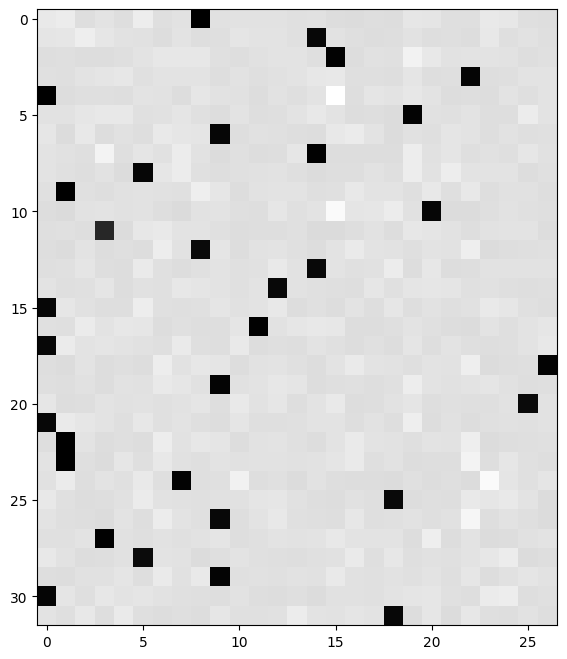

In [ ]:
plt.figure(figsize=(8,8))
plt.imshow(dlogits.detach(), cmap='gray')

In [ ]:
# backprop through batchnorm but all in one go
# to complete this look at the mathematical expression of the output of batchnorm,
# take the derivative w.r.t. its input, simplify the expression, and just write it out
# BatchNorm paper: https://arxiv.org/abs/1502.03167

# forward pass

# before:
# bnmeani = 1/n*hprebn.sum(0, keepdim=True)
# bndiff = hprebn - bnmeani
# bndiff2 = bndiff**2
# bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
# bnvar_inv = (bnvar + 1e-5)**-0.5
# bnraw = bndiff * bnvar_inv
# hpreact = bngain * bnraw + bnbias

# now:
hpreact_fast = bngain * (hprebn - hprebn.mean(0, keepdim=True)) / torch.sqrt(hprebn.var(0, keepdim=True, unbiased=True) + 1e-5) + bnbias
print('max diff:', (hpreact_fast - hpreact).abs().max())

max diff: tensor(0.3153, grad_fn=<MaxBackward1>)


In [ ]:
# backward pass

# before we had:
# dbnraw = bngain * dhpreact
# dbndiff = bnvar_inv * dbnraw
# dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)
# dbnvar = (-0.5*(bnvar + 1e-5)**-1.5) * dbnvar_inv
# dbndiff2 = (1.0/(n-1))*torch.ones_like(bndiff2) * dbnvar
# dbndiff += (2*bndiff) * dbndiff2
# dhprebn = dbndiff.clone()
# dbnmeani = (-dbndiff).sum(0)
# dhprebn += 1.0/n * (torch.ones_like(hprebn) * dbnmeani)

# calculate dhprebn given dhpreact (i.e. backprop through the batchnorm)

# -----------------
dhprebn = bngain*bnvar_inv/n * (n*dhpreact - dhpreact.sum(0) - n/(n-1)*bnraw*(dhpreact*bnraw).sum(0))
# -----------------

cmp('hprebn', dhprebn, hprebn)

hprebn          | exact: False | approximate: True  | maxdiff: 4.656612873077393e-10


In [ ]:
# putting it all together!
# Train the MLP neural net with manual backward pass

# init
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

# same optimization as last time
max_steps = 200000
batch_size = 32
n = batch_size # convenience
lossi = []


with torch.no_grad():

  # kick off optimization
  for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    # Linear layer
    hprebn = embcat @ W1 + b1 # hidden layer pre-activation
    # BatchNorm layer
    # -------------------------------------------------------------
    bnmean = hprebn.mean(0, keepdim=True)
    bnvar = hprebn.var(0, keepdim=True, unbiased=True)
    bnvar_inv = (bnvar + 1e-5)**-0.5
    bnraw = (hprebn - bnmean) * bnvar_inv
    hpreact = bngain * bnraw + bnbias
    # -------------------------------------------------------------
    # Non-linearity
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
      p.grad = None
    # loss.backward() # for correctness comparisons

    # manual backprop

    dlogits = F.softmax(logits, 1)
    dlogits[range(n), Yb] -= 1
    dlogits /= n
    #second linear layer
    dh = dlogits @ W2.T # transpose, no need for real matrix calculus
    dW2 = h.T @ dlogits
    db2 = dlogits.sum(0)
    #tanh
    dhpreact = (1.0 - h**2) * dh
    #batchnorm
    dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
    dbnbias = dhpreact.sum(0, keepdim=True)
    dhprebn = bngain*bnvar_inv/n * (n*dhpreact - dhpreact.sum(0) - n/(n-1)*bnraw*(dhpreact*bnraw).sum(0))
    #first linear layer
    dembcat = dhprebn @ W1.T
    dW1 = embcat.T @ dhprebn
    db1 = dhprebn.sum(0)
    # embedding
    demb = dembcat.view(emb.shape)
    dC = torch.zeros_like(C)
    for k in range(Xb.shape[0]):
      for j in range(Xb.shape[1]):
        ix = Xb[k,j]
        dC[ix] += demb[k,j]
    grads = [dC, dW1, db1, dW2, db2, dbngain, dbnbias]
    # -----------------

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p, grad in zip(parameters, grads):
      #p.data += -lr * p.grad # old way pytorch backward()
      p.data += -lr * grad # Manuel

    # track stats
    if i % 10000 == 0: # print every once in a while
      print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

    #if i >= 20000: # early breaking to test
     #  break

12297
      0/ 200000: 3.7975
  10000/ 200000: 2.1308
  20000/ 200000: 2.4319


with pytorch after 20000 -> 2.3990 loss

with manual backprop after 20000 ->2.4319 loss

pretty close

In [25]:
# calibrate the batch norm at the end of training

with torch.no_grad():
  # pass the training set through
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnvar = hpreact.var(0, keepdim=True, unbiased=True)

In [ ]:
# evaluate train and val loss

@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 + b1
  hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

In [ ]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass
      emb = C[torch.tensor([context])] # (1,block_size,d)
      embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
      hpreact = embcat @ W1 + b1
      hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
      h = torch.tanh(hpreact) # (N, n_hidden)
      logits = h @ W2 + b2 # (N, vocab_size)
      # sample
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break

    print(''.join(itos[i] for i in out))